Example jupyter notebook for the shnitsel.static module

The data is stored in the xarray format, more information on the usage of the xarray python package can be found here: https://docs.xarray.dev/en/stable/index.html



Loading a dataset:

In [1]:
import xarray as xr

data = xr.open_dataset('/home/robin/Documents/Plots_Schnitzel/final_dbs/04_3Sing_C2H4_grid.nc')
data



<xarray.Dataset> Size: 4MB
Dimensions:    (frame: 3731, atom: 6, direction: 3, state: 3, statecomb: 3)
Coordinates:
  * statecomb  (statecomb) object 24B 'S0-S1' 'S0-S2' 'S1-S2'
  * state      (state) object 24B 'S0' 'S1' 'S2'
Dimensions without coordinates: frame, atom, direction
Data variables:
    positions  (frame, atom, direction) float64 537kB ...
    forces     (frame, state, atom, direction) float64 2MB ...
    nacs       (frame, statecomb, atom, direction) float64 2MB ...
    dip_perm   (frame, state, direction) float64 269kB ...
    dip_trans  (frame, statecomb, direction) float64 269kB ...
    energy     (frame, state) float64 90kB ...
    symbols    (atom) object 48B ...

Plotting property distributions as histograms:

If the shape of the properties is (n_frames, n_states, n_atoms, 3), the frobenius norm will automaticall be applied along the last two dimensions -> (n_frames, n_states)

If the shape of the properties is (n_frames, n_states, 3), the vector norm will automatically be applied along the last dimension -> (n_frames, n_states)

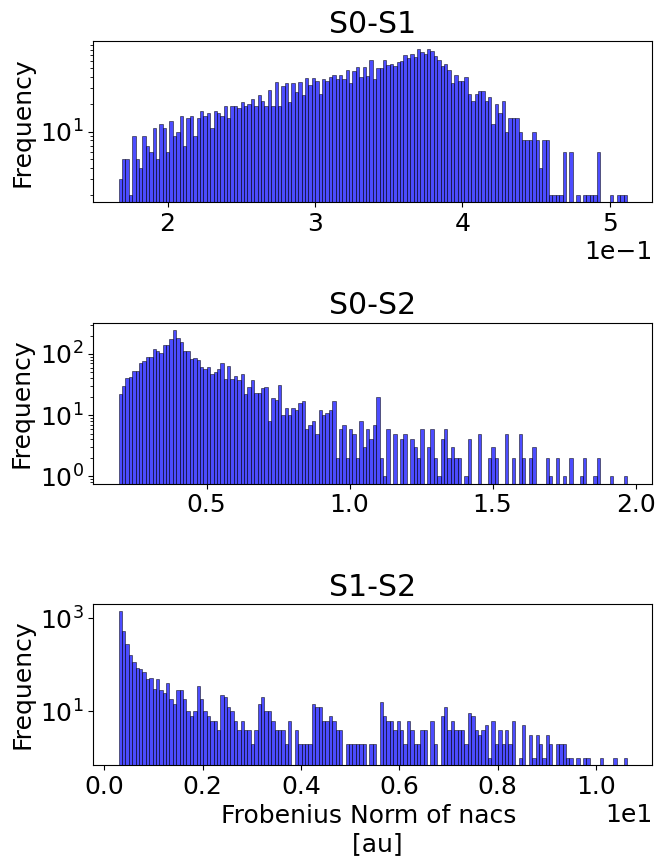

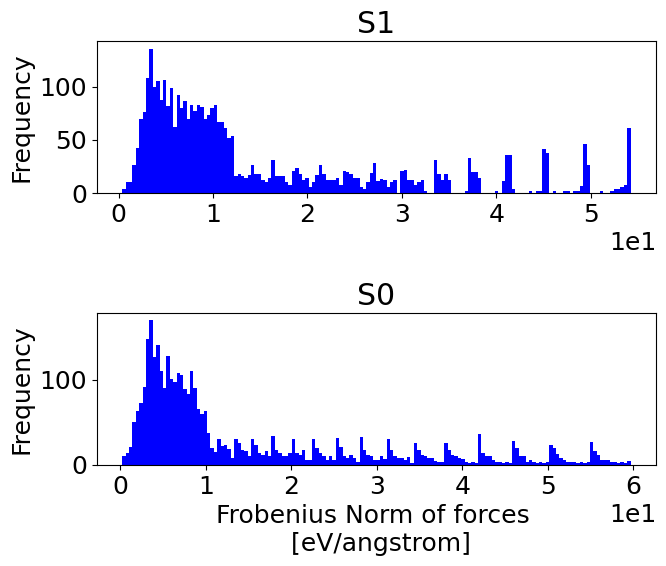

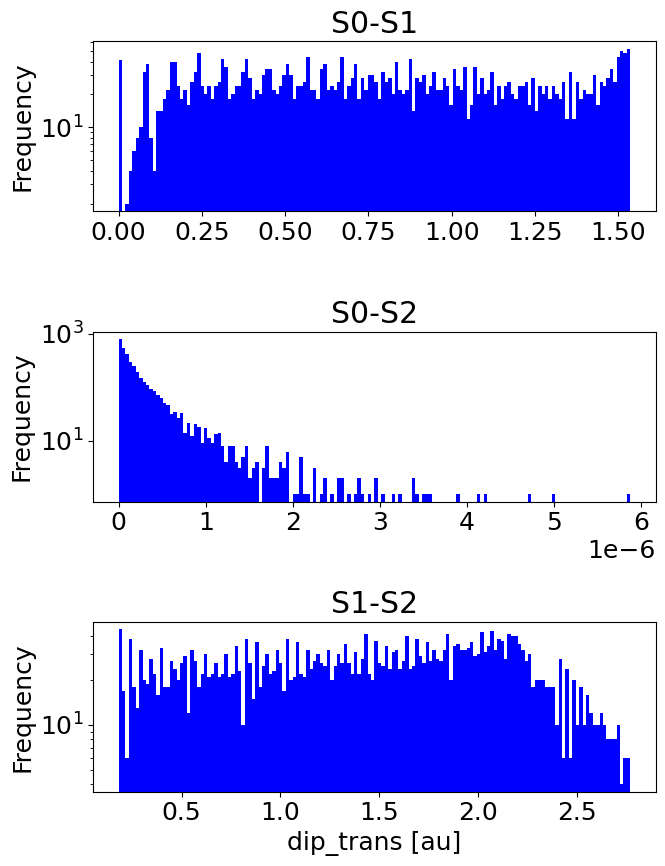

In [3]:
from shnitsel.static import plot_hist
from shnitsel.static import convert_distance, convert_force
from shnitsel.dynamic.postprocess import convert_energy


# optional arguments for the histogram
hist_kwargs = { 
    'alpha': 0.7,
    'edgecolor': 'black',
    'linewidth': 0.5
}

# convert force to eV/angstrom
forces = convert_force(data.forces, 'eV/angstrom')

# to plot all states in different subplots
fig, ax = plot_hist(data.nacs, num_bins=150, scale_type='log', hist_kwargs=hist_kwargs)

# to plot selected states in different subplots
fig, ax = plot_hist(forces, num_bins=150, scale_type='linear', states=['S1', 'S0'])

# to combine all states in one histogram
fig, ax = plot_hist(data.dip_trans, num_bins=150, scale_type='log', combine_states=False)

Plotting the energy histrograms as heatmap histograms

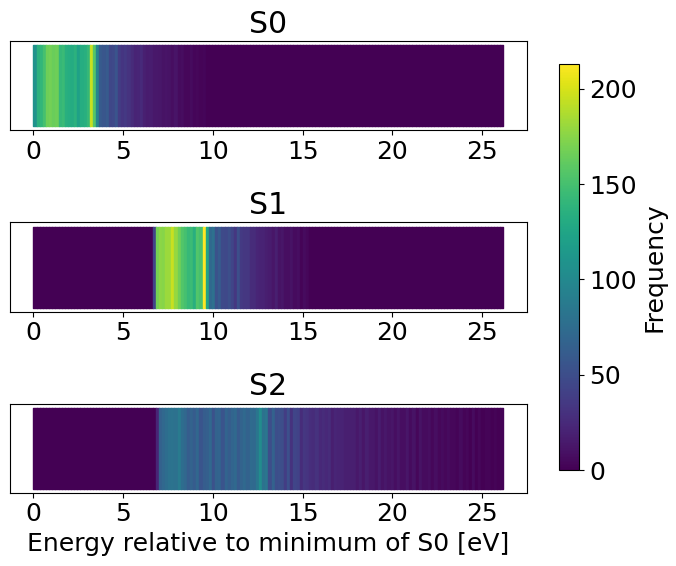

In [4]:
# to plot the energy distributions in another way of visualization, use the following function

from shnitsel.static import plot_color_hist  
from shnitsel.dynamic.postprocess import convert_energy

energies = data.energy
energies = energies - energies.sel(state='S0').min() # set minimum to zero
energies.attrs = data.energy.attrs
energies = convert_energy(energies, 'eV') # convert to eV
energies.name = 'Energy relative to minimum of S0' # set new name

energies = energies.transpose() # bring state dimension to the first position, the function will create a histogram for each state


fig, ax = plot_color_hist(energies, num_bins=150)

To create SOAP descriptors for the data, you can use the following tool

Note: the dscribe package (https://singroup.github.io/dscribe/latest/) must be installed into the python environment to use the following functionalities 

In [5]:
from shnitsel.static import SOAP_creator

soap_creator = SOAP_creator(species=['C', 'H'], rcut=5.0, nmax=8, lmax=6)

soap_descriptors = soap_creator.create_descriptors(data)
print(soap_descriptors.shape)

Creating SOAP descriptors using 36 cores
(3731, 6, 952)


Using global pooling of the SOAP descriptors to get a fixed-size molecular SOAP descriptor

pooling options are: 'inner' -> inner product; 'outer' -> outer product, 'off' -> no pooling
default option: 'off'

In [7]:
soap_creator = SOAP_creator(species=['C', 'H', 'N'], rcut=5.0, nmax=8, lmax=6, average='inner')
soap_descriptors = soap_creator.create_descriptors(data)
print(soap_descriptors.shape)


Creating SOAP descriptors using 36 cores
(3731, 2100)


Dimensionality Reduction of the SOAP descriptors using PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler  

pca = PCA(n_components=3)
scaler = MinMaxScaler()
descriptors = scaler.fit_transform(soap_descriptors)
pca_res = pca.fit_transform(descriptors)
print(f'Explained variance: {pca.explained_variance_ratio_}')  

Explained variance: [0.44181055 0.26564671 0.13070245]


Plotting the PCA result

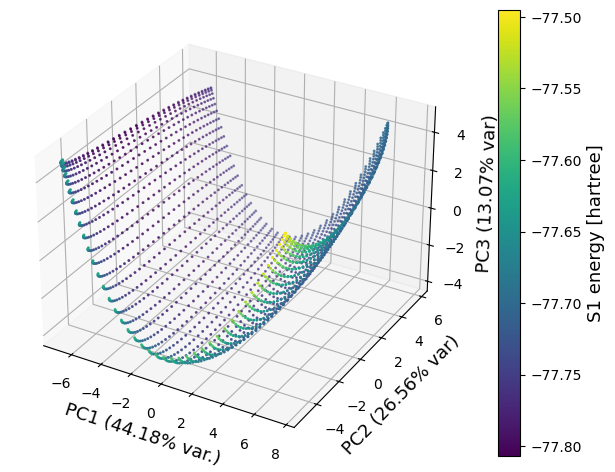

In [9]:
# the PCA can be colored by any scalar property of the data, e.g. the energy of the ground state
from shnitsel.static import pca_plot

color_prop=data.energy.sel(state='S1')
fig = pca_plot(pca_res=pca_res, explained_variance=pca.explained_variance_ratio_, color_prop=color_prop)

It can often be helpful to display the molecule's connectivity and the indices of the atoms. We provide a function which can do this. 

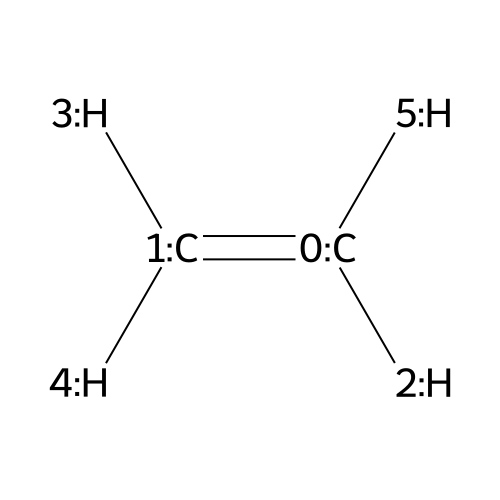

In [2]:
from shnitsel.static import display_atom_indices

pos = data.positions.sel(frame=0) # positions of the atoms in the first frame
symb = data.symbols.values # symbols of the atoms
charge = 0 # the function only works if you provide the correct molecular charge

img = display_atom_indices(pos, symb, charge=charge) # display the indices of the atoms
display(img)

The knowledge about atom indices can now be used to plot property dependencies on the H-C-C-H dihedral angle.

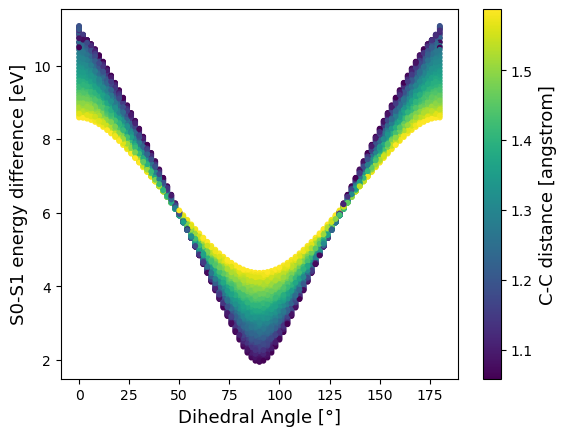

In [11]:
from shnitsel.static import convert_distance, vector_norm
from shnitsel.dynamic.postprocess import convert_energy
from shnitsel.static import dihedral_plot

# calculate S0-S1 energy difference
s1_s0 = data.energy.sel(state='S1') - data.energy.sel(state='S0')
s1_s0.attrs = data.energy.sel(state='S1').attrs
s1_s0.name = 'S0-S1 energy difference' 

# calculate C-C distance using the indices of the carbon atoms
c1c2 = data.positions.sel(atom=1) - data.positions.sel(atom=0)
c1c2.attrs = data.positions.sel(atom=1).attrs
c1c2 = convert_distance(c1c2, 'angstrom') # convert the distance to angstrom
cc_distance = vector_norm(c1c2) 
cc_distance.name = 'C-C distance'

s1_s0 = convert_energy(s1_s0, 'eV')  # convert the energy to eV

# plot the dihedral angle of the molecule
fig, ax, scatter = dihedral_plot(data.positions, dihedral_indices=[3, 1, 0, 2], # indices of the H-C-C-H dihedral
                                 prop=s1_s0, color_prop=cc_distance)

/tmp/ipykernel_3387328/1859728607.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


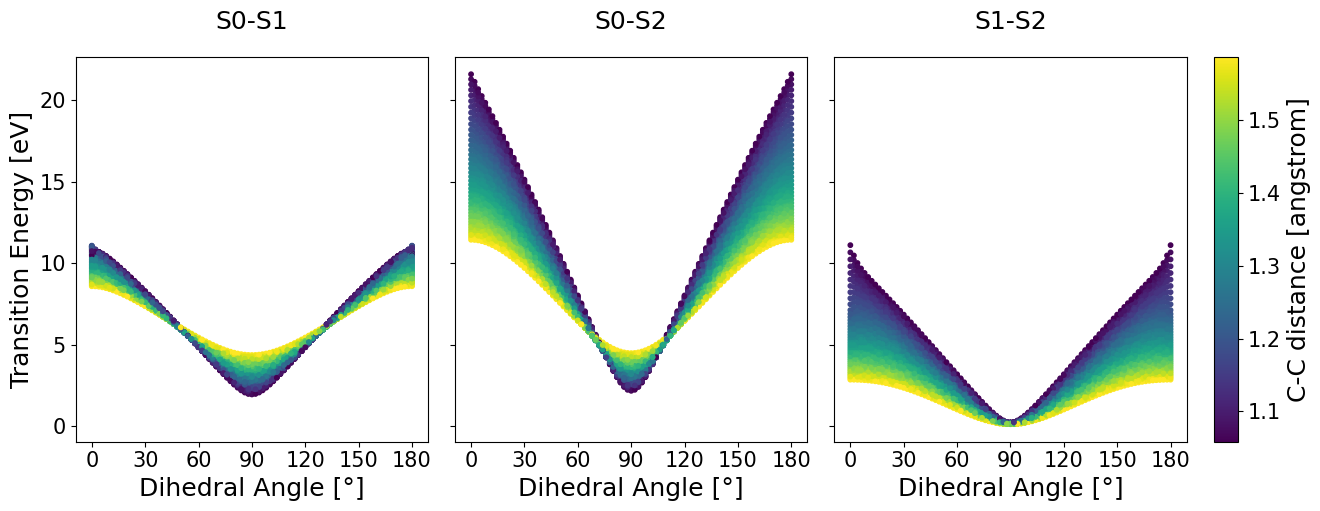

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shnitsel.dynamic.postprocess import convert_energy

# Set figure parameters for better readability and layout
fig_params = {
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
}
plt.rcParams.update(fig_params)

# Compute global color limits from cc_distance
vmin = cc_distance.min().item()
vmax = cc_distance.max().item()

# Create a figure using GridSpec: three subplots and one narrow column for the colorbar
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.07], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)
cbar_ax = fig.add_subplot(gs[3])

s1_s0 = data.energy.sel(state='S1')-data.energy.sel(state='S0')
s1_s0.attrs['units'] = data.energy.attrs.get("unit")
s1_s0 = convert_energy(s1_s0, 'eV')

s2_s0 = data.energy.sel(state='S2')-data.energy.sel(state='S0')
s2_s0.attrs['units'] = data.energy.attrs.get("unit")
s2_s0 = convert_energy(s2_s0, 'eV')

s2_s1 = data.energy.sel(state='S2')-data.energy.sel(state='S1')
s2_s1.attrs['units'] = data.energy.attrs.get("unit")
s2_s1 = convert_energy(s2_s1, 'eV')

dihedral_indices = [3, 1, 0, 2]


_, ax1, scatter1 = dihedral_plot(data.positions, dihedral_indices,
                                 prop=s1_s0, color_prop=cc_distance,
                                 ax=ax1)
_, ax2, scatter2 = dihedral_plot(data.positions, dihedral_indices,
                                 prop=s2_s0, color_prop=cc_distance,
                                 ax=ax2)
_, ax3, scatter3 = dihedral_plot(data.positions, dihedral_indices,
                                 prop=s2_s1, color_prop=cc_distance,
                                 ax=ax3)

# Apply the same color scale for each subplot
for ax in (ax1, ax2, ax3):
    ax.collections[0].set_clim(vmin, vmax)

# Ensure ax1 displays y tick labels while hiding them on ax2 and ax3
ax1.tick_params(labelleft=True)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(f'Transition Energy [{s1_s0.attrs.get("units", "unknown")}]')
ax2.set_ylabel('')
ax3.set_ylabel('')
x_ticks = [0, 30, 60, 90, 120, 150, 180]
ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)
ax3.set_xticks(x_ticks)

# Set titles for each subplot
ax1.set_title('S0-S1')
ax2.set_title('S0-S2')
ax3.set_title('S1-S2')

# Create one global colorbar in the dedicated axis (cbar_ax)
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax, orientation='vertical')
cbar.set_label(f'{cc_distance.name} [{cc_distance.attrs.get("units", "unknown")}]')
plt.tight_layout()
#plt.savefig('dihedral_plot_C4H8_grid.png', dpi=600)
plt.show()

Create Distance-Energy scatterplot for CSH2

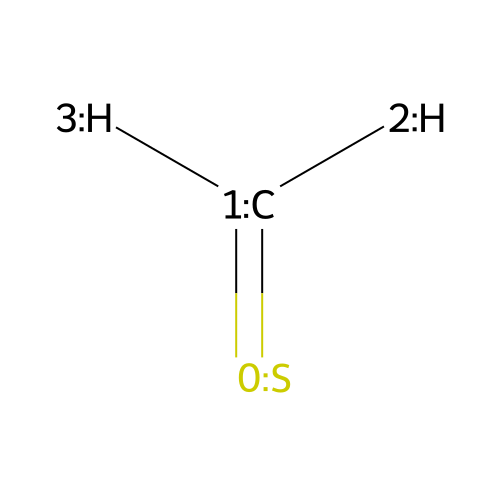

In [13]:
from shnitsel.dynamic.postprocess import convert_energy
from shnitsel.static import display_atom_indices

data = xr.open_dataset('/home/robin/Documents/Plots_Schnitzel/final_dbs/CSH2.nc')
data

pos = data.positions.sel(frame=0) # positions of the atoms in the first frame
symb = data.symbols.values # symbols of the atoms

img = display_atom_indices(pos, symb, charge=0) # display the molecule with atom indices
display(img)



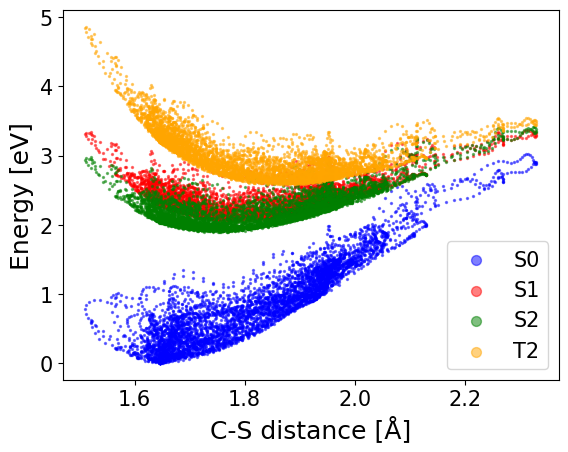

In [14]:
from shnitsel.static import vector_norm
from shnitsel.static import convert_distance
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

cs_distance = vector_norm(data.positions.sel(atom=1) - data.positions.sel(atom=0)) # insert indices of C (1) and S (0) atoms
cs_distance.attrs = data.positions.attrs
cs_distance = convert_distance(cs_distance, 'angstrom')

energies = convert_energy(data.energy, 'eV')
energies = energies - energies.sel(state='S0').min()    


s = 2
alpha = 0.5
plt.scatter(cs_distance, energies.sel(state='S0'), c='blue', label='S0', s=s, alpha=alpha)
plt.scatter(cs_distance, energies.sel(state='S1'), c='red', label='S1', s=s, alpha=alpha)
plt.scatter(cs_distance, energies.sel(state='T1'), c='green', label='S2', s=s, alpha=alpha)
plt.scatter(cs_distance, energies.sel(state='T2'), c='orange', label='T2', s=s, alpha=alpha)  

plt.xlabel('C-S distance [Å]')
plt.ylabel('Energy [eV]')

plt.legend(markerscale=5)
plt.savefig('energy_distance_plot_csh2.png', dpi=600, bbox_inches='tight')
plt.show()
